In [47]:
#データ収集
import pandas as pd
data1 = pd.read_csv('stocks_9984-T_1d_2016.csv',encoding='shift-jis')
data2 = pd.read_csv('stocks_9984-T_1d_2017.csv',encoding='shift-jis')
data = pd.concat([data1,data2])
data = data.sort_values(by='日付')
data = data.reset_index(drop=True)

In [48]:
#データ探索
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 455 entries, 0 to 454
Data columns (total 7 columns):
日付      455 non-null object
始値      455 non-null float64
高値      455 non-null float64
安値      455 non-null float64
終値      455 non-null float64
出来高     455 non-null int64
売買代金    455 non-null int64
dtypes: float64(4), int64(2), object(1)
memory usage: 25.0+ KB


In [49]:
#データ探索
data.describe()

,始値,高値,安値,終値,出来高,売買代金
count,455.000000,455.000000,455.000000,455.000000,4.550000e+02,4.550000e+02
mean,7360.261538,7436.536264,7281.030769,7355.936264,7.558784e+06,5.382970e+10
std,1485.079054,1479.383908,1490.662613,1486.680226,5.436376e+06,3.465014e+10
min,4340.000000,4440.000000,4133.000000,4164.000000,2.966300e+06,1.698517e+10
25%,5949.000000,6045.500000,5869.500000,5992.500000,4.795550e+06,3.457382e+10
50%,6980.000000,7012.000000,6922.000000,6956.000000,6.145600e+06,4.457785e+10
75%,8731.500000,8791.000000,8652.000000,8693.500000,8.583750e+06,6.139343e+10
max,10440.000000,10550.000000,10365.000000,10430.000000,7.737260e+07,4.299855e+11


In [50]:
#前処理
from sklearn import preprocessing
data['終値'] = preprocessing.scale(data['終値'])
data = data.loc[:,['日付','終値']]

In [51]:
#モデル選択
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers.core import Dense,Activation
from keras.layers.recurrent import LSTM

Using TensorFlow backend.


In [56]:
#モデル選択
class Prediction:
    def __init__(self):
        self.length_of_sequences = 10
        self.in_out_neurons = 1
        self.hidden_neurons = 300
    def load_data(self, data, n_prev=10):
        X,Y = [],[]
        for i in range(len(data) - n_prev):
            X.append(data.iloc[i:(i+n_prev)].as_matrix())
            Y.append(data.iloc[i+n_prev].as_matrix())
        retX = np.array(X)
        retY = np.array(Y)
        return retX, retY
    def create_model(self):
        model = Sequential()
        model.add(LSTM(self.hidden_neurons,
                      batch_input_shape = (None,self.length_of_sequences,self.in_out_neurons),
                      return_sequences=False))
        model.add(Dense(self.in_out_neurons))
        model.add(Activation('linear'))
        model.compile(loss='mape',optimizer='adam')
        return model
    def train(self,X_train,y_train):
        model = self.create_model()
        model.fit(X_train,y_train,batch_size=10,nb_epoch=100)
        return model

In [85]:
if __name__ == '__main__':#直接実行された場合のみ実行し、それ以外の場合は実行しない
    prediction = Prediction()

In [86]:
#データ分割
# split = int(len(data)*0.9)
# X = data.iloc[:split,:]
# y = data.iloc[split:,:]

# # from sklearn.model_selection import train_test_split
# # X_train,y_train,X_test,y_test = train_test_split(X,y,test_size=0.1,random_state=0)

In [87]:
#データ分割
split_pos = int(len(data) * 0.8)
x_train, y_train = prediction.load_data(data[['終値']].iloc[0:split_pos],prediction.length_of_sequences)
x_test, y_test = prediction.load_data(data[['終値']].iloc[split_pos:],prediction.length_of_sequences)

In [100]:
x_test.shape

(81, 10, 1)

In [88]:
model = prediction.train(x_train,y_train)

/Users/sakashitatakuji/anaconda/lib/python3.6/site-packages/keras/models.py:851: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/100
354/354 [==============================] - 2s - loss: 36.2151       

In [98]:
predicted = model.predict(x_test)
result = pd.DataFrame(predicted)
result.columns = ['predict']
result['actual'] = y_test

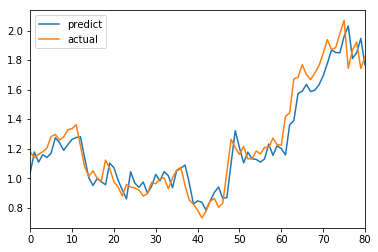

In [99]:
result.plot()
plt.show()

In [106]:
np.sum(y_test-predicted)

1.946302075437095